In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [2]:
files = glob.glob('*txt')
files = [i.replace(".txt", "") for i in files]
files

['O12_J10_D3_3',
 'K10_F23_F12_1',
 'A10_D11_B18_2',
 'K10_F23_F12_2',
 'A10_D11_B18_1',
 'A10_D11_B18_3',
 'O12_J10_D3_1',
 'O12_J10_D3_2']

In [3]:
data = pd.DataFrame()
for sample in files:
    df = pd.read_csv(f"{sample}.txt", sep="\t")
    df.columns = ["Image", "CRE-CRE", "CRE-Control"]
    df["sample"] = "_".join(sample.split("_")[0:3])
    df["replicate"] = "Rep. " + sample.split("_")[3]
    data = pd.concat([data, df])
data

,Image,CRE-CRE,CRE-Control,sample,replicate
0,1,"0,891","1,28",O12_J10_D3,Rep. 3
1,1,"1,03","1,49",O12_J10_D3,Rep. 3
2,1,"1,31","0,849",O12_J10_D3,Rep. 3
3,1,"1,21","1,06",O12_J10_D3,Rep. 3
4,1,"3,06","3,21",O12_J10_D3,Rep. 3
...,...,...,...,...,...
88,40007,"2,06","2,21",O12_J10_D3,Rep. 2
89,40007,"1,96","1,67",O12_J10_D3,Rep. 2
90,40008,"0,447","0,346",O12_J10_D3,Rep. 2
91,40010,"2,11","1,43",O12_J10_D3,Rep. 2


In [4]:
data["replicate"].unique()

array(['Rep. 3', 'Rep. 1', 'Rep. 2'], dtype=object)

In [5]:
data = data.apply(lambda x: x.str.replace(',','.'))
data[["CRE-CRE", "CRE-Control"]] = data[["CRE-CRE", "CRE-Control"]].astype(float)

In [6]:
data["chromosome"] = np.where(data["sample"] == "O12_J10_D3",
                              "chr9",
                              np.where(data["sample"] == "A10_D11_B18",
                                       "chr1",
                                       np.where(data["sample"] == "A10_D11_B18",
                                       "chr1",
                                       np.where(data["sample"] == "K10_F23_F12",
                                                "chrX", "ERROR"))))

In [7]:
melt = pd.melt(data, id_vars=["Image", "sample", "chromosome", "replicate"])

In [8]:
melt["sample_rep"] = melt["sample"] + "_" + melt["replicate"]

In [9]:
melt = melt.sort_values("chromosome").reset_index(drop=True)

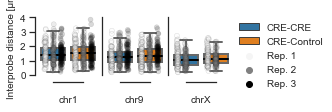

In [10]:
cm = 1/2.54
sns.set(style="ticks", font="Arial")
sns.set_context("notebook", rc={"font.size":1,
                                "axes.labelsize": 10,
                                "xtick.labelsize": 10,
                                "ytick.labelsize": 10})   
melt['variable'] = pd.Categorical(melt['variable'], ['CRE-CRE', 'CRE-Control'])
melt['replicate'] = pd.Categorical(melt['replicate'], ['Rep. 1', 'Rep. 2', 'Rep. 3'])
props = {
    'boxprops':{'edgecolor':'dimgrey'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'dimgrey'},
    'capprops':{'color':'dimgrey'}
}
g = sns.catplot(data=melt, kind='box', 
                x='variable', y='value', col='chromosome',
                dodge=False, showfliers=False, height=5*cm, aspect=0.6,
                linewidth=2, hue="variable", legend=False, **props,
                palette=["#1f78b4", "#ff7f00"])
g.map_dataframe(sns.stripplot, x='variable', y='value', hue='replicate', 
                size=5, dodge=True, edgecolor="k", linewidth=0.5,
                palette=['whitesmoke','grey','black'], alpha=0.15)
g.add_legend(title="", fontsize=10)
plt.setp(g._legend.get_title(), fontsize=10)
g.set_titles(col_template = '{col_name}')

for ax in g.axes.flat:
    ax.set_xlabel(ax.get_title(), size=10)
    ax.set_xticklabels("")
    ax.set_title('')
    ax.tick_params(bottom=False)
    if len(ax.get_ylabel()) == 0:
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', left=False)
    else:
        ax.set_ylabel("Interprobe distance [µm]", size=10)
        ax.set_yticks([0, 1, 2, 3, 4])
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin - 0.1, xmax + 0.1)
ax.set_ylim(-0.5, 4.75)
plt.subplots_adjust(wspace=0)
sns.despine(trim=True)
plt.savefig("DNA_FISH_distances.svg", bbox_inches="tight")

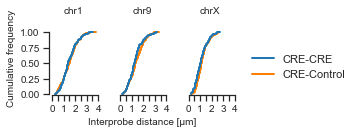

In [11]:
g = sns.displot(
    melt,
    x="value", col="chromosome", hue="variable",
    kind="ecdf", aspect=0.6, linewidth=2, height=5*cm,
    palette=["#1f78b4", "#ff7f00"]
)
g.legend.set_title(None)
g.set_titles(col_template = '{col_name}')
g.set(xticks=np.linspace(0, 4, 9),
      xticklabels=[0, "", 1, "", 2, "", 3, "", 4],
      xlim=[-0.25, 4],
      yticks=[0, 0.25, 0.5, 0.75, 1],
      ylim=[-0.02, 1.2])
sns.despine(trim=True)
for ax in g.axes.flat:
    if ax.get_title() == "chr9":
        ax.set_xlabel("Interprobe distance [µm]", size=10)
    else:
        ax.set_xlabel("")
    if len(ax.get_ylabel()) == 0:
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', left=False)
    else:
        ax.set_ylabel("Cumulative frequency", size=10)
plt.savefig("DNA_FISH_ecdf.svg", bbox_inches="tight")

In [12]:
melt.to_csv("DNA_FISH_processed.tsv", sep="\t", index=False)

In [13]:
melt.groupby(["chromosome", "variable"]).size()

chromosome  variable   
chr1        CRE-CRE        289
            CRE-Control    289
chr9        CRE-CRE        292
            CRE-Control    292
chrX        CRE-CRE        208
            CRE-Control    208
dtype: int64

In [14]:
melt.groupby(["chromosome", "variable"]).median("value")

value
chromosome variable          
chr1       CRE-CRE      1.380
           CRE-Control  1.520
chr9       CRE-CRE      1.230
           CRE-Control  1.310
chrX       CRE-CRE      1.040
           CRE-Control  1.125